In [14]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score, mean_squared_error
INF = np.inf

In [4]:
mat = spio.loadmat('MUTAG.mat', squeeze_me = True)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
N = np.size(mutag)

tol = 0
#get total number of nodes in the dataset  
for i in range(N):
        graph = mutag[i]
        tol += len(graph[1].tolist()[0])

### WL Shortest Path Kernel

In [5]:
def original_count(nl, Map, ctr): 
    num_labels = nl.shape[0]
    labels = np.zeros(num_labels) 
    
    for i in range(num_labels): 
        str_label = str(nl[i]) 
        if(str_label in Map): 
            labels[i] = Map[str_label] 
        else: 
            Map[str_label] = ctr
            labels[i] = ctr
            ctr += 1 
        
    labels = np.int64(labels)
    return {'labels': labels, 'Map': Map, 'ctr': ctr}
    

In [6]:
def compress_label(nl, am):  
    Map = dict(); ctr = 0
    phi1 = []
    phi2 = [] 
    new_labels = np.zeros(nl.shape[0])
    for i in range(nl.shape[0]): 
        neighbors_labels = nl[np.where(am[i] == 1)]
        str_label = str(nl[i])
        
        for neighbor in range(neighbors_labels.shape[0]): 
            str_label += str(neighbor)
        
        if(str_label in Map): 
            new_labels[i] = Map[str_label]
        else: 
            Map[str_label] = ctr
            new_labels[i] = ctr
            ctr += 1 
            
    return {'new_labels': new_labels, 'Map': Map, 'ctr': ctr} 

### Floyd-Warshall Algorithm

In [7]:
"""
Get the shortest path by Floyd-Warshall Algorithm. 
Complexity: O(|V|^3)
"""
def floyd_warshall (am): 
    """
    am: adjacent matrix 
    
    """
    
    n = am.shape[0]; 
    dp = np.zeros([n, n])
    
    #step 1: initialize dp matrix  
    for i in range(n): 
        for j in range(n): 
            if (i != j):                 
                if (am[i, j] == 0): 
                    dp[i, j] = INF
                else:
                    dp[i, j] = am[i, j]
        
    #sp(i, j, k) = min(sp(i, j, k - 1), sp(i, k, k - 1) + sp(k, j, k - 1))
    for k in range(n):
        for i in range(n): 
            for j in range(n): 
                if (dp[i, k] + dp[k, j] < dp[i, j]): 
                    dp[i, j] = dp[i, k] + dp[k, j]
    
    return dp.astype(int)       

In [8]:
"""
Find all triplet (a, b, p) in graph G, and count the 
number of occurences of (a, b, p), where: 
  (a, b) are ordered endpoint labels of a shortest path 
   p is the shortest path length. 

return: map(key: "p-a-b", value: # of occurence of key)
   
"""

def get_triplet_map(nl, am, s): 
    """
    Parameters
    ----------
    nl: node labels 
    am: adjacent matrix  
    s: floyd-transformed graph, whose element 
    is the shortest path between two nodes.  
    """
    
    triplet_map = dict()
    
    for p in np.unique(s): 
        if (p == 0): 
            continue 
            
        index = np.where(s == p) 
        row = index[0]
        col = index[1] 
        n_p = len(row)
        
        for k in range(n_p): 
            i = row[k] #node 1 index
            j = col[k] #node 2 index
            a = nl[i] #node 1 label
            b = nl[j] #node 2 label 
            triplet = str(p) + "-" + str(a) + "-" + str(b) #map key: "p-a-b"
            if (triplet in triplet_map): 
                triplet_map[triplet] += 1; 
            else:
                triplet_map[triplet] = 1;  
            
    return triplet_map

"""
get_edge_map(l1, am1, floyd_warshall(am1))
return: 
{'1-3-3': 48, '1-3-6': 1, '1-6-3': 1, '1-6-7': 2, '1-7-6': 2, ...
"""

"\nget_edge_map(l1, am1, floyd_warshall(am1))\nreturn: \n{'1-3-3': 48, '1-3-6': 1, '1-6-3': 1, '1-6-7': 2, '1-7-6': 2, ...\n"

### WL shortest path kernel function

In [9]:
def wl_sp_kernel(graph1, graph2, H):
    K = 0; 
    
    #read graph structure 
    am1, l1 = graph1[0], graph1[1]
    am2, l2 = graph2[0], graph2[1]
    l1 = l1.tolist()[0]
    l2 = l2.tolist()[0]
    
    ###Step 1: Initialization/original count
    Map = dict();
    ctr = 0 
    
    #for graph 1 
    res1 = original_count(l1, Map, ctr)
    Map = res1['Map']
    ctr = res1['ctr']
    
    #for graph 2
    res2 = original_count(l2, Map, ctr)
    Map = res2['Map']
    ctr = res2['ctr']
    
    #get initial labels  
    labels1 = res1['labels']
    labels2 = res2['labels']
    
    ###Step 2: Compute shortest paths in a graph by Floyd-Warshal 
    #Let s1 and s2 be the Floyd-transformed graphs 
    s1 = floyd_warshall(am1)
    s2 = floyd_warshall(am2)
    
    ###Step 3: Count pairs of labeled nodes with identical shortest path length
    triplet_map1 = get_triplet_map(labels1, am1, s1)
    triplet_map2 = get_triplet_map(labels2, am2, s2)
    
    
    ###Step 4: Compute inner product of triplet_map1 & triplet_map2 
    triplet1 = set(triplet_map1.keys())
    triplet2 = set(triplet_map2.keys())
    all_triplet = triplet1 | triplet2 
    phi1 = []
    phi2 = []
    for t in all_triplet: 
        phi1.append(triplet_map1[t] if t in triplet1 else 0)
        phi2.append(triplet_map2[t] if t in triplet2 else 0)
    
    K += np.dot(np.asmatrix(phi1), np.asmatrix(phi2).T) 
    
    ###Step 5: Repeat the above process for H iterations. 
    for h in range(H): 
        ###Step 5.a: get compressed labels  
        
        #for graph 1 
        res1 = compress_label(labels1, am1)
        Map = res1['Map']
        ctr = res1['ctr']

        #for graph 2
        res2 = compress_label(labels2, am2)
        Map = res2['Map']
        ctr = res2['ctr']

        #update labels for h-th iteration
        labels1 = res1['new_labels']
        labels2 = res2['new_labels']
        
        ###Step 5.b: Compute shortest paths in a graph by Floyd-Warshal 
        #Let s1 and s2 be the Floyd-transformed graphs 
        s1 = floyd_warshall(am1)
        s2 = floyd_warshall(am2)

        ###Step 5.c: Count pairs of labeled nodes with identical shortest path length
        triplet_map1 = get_triplet_map(labels1, am1, s1)
        triplet_map2 = get_triplet_map(labels2, am2, s2)


        ###Step 5.d: Compute inner product of triplet_map1 & triplet_map2 
        triplet1 = set(triplet_map1.keys())
        triplet2 = set(triplet_map2.keys())
        all_triplet = triplet1 | triplet2 
        phi1 = []
        phi2 = []
        for t in all_triplet: 
            phi1.append(triplet_map1[t] if t in triplet1 else 0)
            phi2.append(triplet_map2[t] if t in triplet2 else 0)

        K += np.dot(np.asmatrix(phi1), np.asmatrix(phi2).T) 
        
    return K    

### Permute, split and evaluate performances of Kernel-based SVM

In [16]:
mat = spio.loadmat('MUTAG.mat', squeeze_me = True)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
y = lmutag
X = mutag
print("X shape: ", mutag.shape)
print("Y shape: ", lmutag.shape)
N = y.shape[0]

"""
Compute accuracy of SVM 

Parameters:  
------------
K: precomputed Kernel matrix 
N: data set size 
c: penalty for SVC
"""
def get_accuracy (K, N, c): 
    #Paper: To exclude random effects of fold assignments, 
    #each repeat experiment 10 times  

    #Record the performance for each parameter trial on test set
    perf_all_val = []

    for t in range(10):  

        random_state = int(t)
        np.random.seed(random_state)
        idx_perm = np.random.permutation(N)

        #Permute the data 
        y_perm = y[idx_perm]
        K_perm = K[:, idx_perm]
        K_perm = K_perm[idx_perm, :]

        #The paper use 10-folder CV (training: 90%; test: 10%)
        num_train = int (N * (9/10))
        num_test = N - num_train 

        #Split the kernel matrix 
        K_train = K_perm[0:num_train, 0:num_train] 
        K_test = K_perm[num_train:N, 0:num_train]
        y_train = y_perm[0:num_train]
        y_test = y_perm[num_train:N]

        #print("K_train shape: ", K_train.shape, "  y_train shape: ", y_train.shape)
        #print("K_test shape:  ", K_test.shape,  "  y_test shape: ", y_test.shape)


        #Fit classifier on training data 
        clf = svm.SVC(kernel = 'precomputed', C = c)
        clf.fit(K_train, y_train)

        #predict on test  
        y_pred_test = clf.predict(K_test)

        #accuracy on test set  
        acc = accuracy_score(y_test, y_pred_test);
        perf_all_val.append(acc) 

        #print("The performance on the test set is: %3f" % acc)

    print("\n average performan: ", np.mean(perf_all_val))
    return np.mean(perf_all_val)



c_grid = np.array([0.01, 0.1, 1, 10, 100, 1000])
h_grid = [x + 1 for x in list(range(10))]


perf = []
h_para = [] 
c_para = [] 
for h in h_grid: 
    for c in c_grid:  
        
        h_para.append(h)
        c_para.append(c)
        print("h: ", h, " c: ", c)
        
        #compute Kernel matrix K, given H  
        K = np.zeros([N, N])
        for i in range(N): 
            for j in range(N):
                if (i <= j ):
                    graph1 = X[i, ]
                    graph2 = X[j, ]
                    K[i, j] = wl_sp_kernel(graph1, graph2, h)
                else: 
                    K[i, j] = K[j, i]
        
        acc = get_accuracy(K, N, c)
        perf.append(acc)
        h_para.append(h)
        c_para.append(c)

X shape:  (188,)
Y shape:  (188,)
h:  1  c:  0.01

 average performan:  0.857894736842
h:  1  c:  0.1

 average performan:  0.826315789474
h:  1  c:  1.0

 average performan:  0.826315789474
h:  1  c:  10.0

 average performan:  0.826315789474
h:  1  c:  100.0

 average performan:  0.826315789474
h:  1  c:  1000.0

 average performan:  0.826315789474
h:  2  c:  0.01

 average performan:  0.836842105263
h:  2  c:  0.1

 average performan:  0.821052631579
h:  2  c:  1.0

 average performan:  0.810526315789
h:  2  c:  10.0

 average performan:  0.810526315789
h:  2  c:  100.0

 average performan:  0.810526315789
h:  2  c:  1000.0

 average performan:  0.810526315789
h:  3  c:  0.01

 average performan:  0.847368421053
h:  3  c:  0.1

 average performan:  0.815789473684
h:  3  c:  1.0

 average performan:  0.815789473684
h:  3  c:  10.0

 average performan:  0.815789473684
h:  3  c:  100.0

 average performan:  0.815789473684
h:  3  c:  1000.0

 average performan:  0.815789473684
h:  4  c:

KeyboardInterrupt: 

## Plots

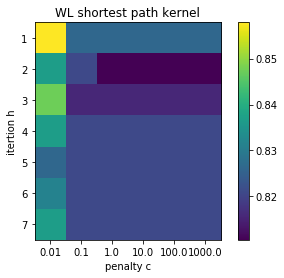

In [41]:
fig = plt.figure()
grid = np.asarray(perf).reshape(len(h_grid) - 3, len(c_grid))
plt.imshow(grid)
y = np.array([0, 1, 2, 3, 4, 5, 6])
x = np.array([0, 1, 2, 3, 4, 5])
plt.xticks(x, c_grid)
plt.yticks(y, h_grid)
plt.xlabel('penalty c')
plt.ylabel('itertion h')
plt.title('WL shortest path kernel')
plt.colorbar()
plt.show()

fig.savefig('graph_sp.png')


## Optimal Parameters

In [42]:
print(max(perf))
h = 1; c = 0.01

0.857894736842


In [44]:
#Compute optimal Kernel matrix 
mat = spio.loadmat('MUTAG.mat', squeeze_me = True)
mutag = mat['MUTAG']
lmutag = mat['lmutag']
y = lmutag
X = mutag
#compute Kernel matrix K, given H  
K = np.zeros([N, N])
for i in range(N): 
    print("i: ", i)
    for j in range(N):
        if (i <= j ):
            graph1 = X[i, ]
            graph2 = X[j, ]
            K[i, j] = wl_sp_kernel(graph1, graph2, h)
        else: 
            K[i, j] = K[j, i]

i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
i:  16
i:  17
i:  18
i:  19
i:  20
i:  21
i:  22
i:  23
i:  24
i:  25
i:  26
i:  27
i:  28
i:  29
i:  30
i:  31
i:  32
i:  33
i:  34
i:  35
i:  36
i:  37
i:  38
i:  39
i:  40
i:  41
i:  42
i:  43
i:  44
i:  45
i:  46
i:  47
i:  48
i:  49
i:  50
i:  51
i:  52
i:  53
i:  54
i:  55
i:  56
i:  57
i:  58
i:  59
i:  60
i:  61
i:  62
i:  63
i:  64
i:  65
i:  66
i:  67
i:  68
i:  69
i:  70
i:  71
i:  72
i:  73
i:  74
i:  75
i:  76
i:  77
i:  78
i:  79
i:  80
i:  81
i:  82
i:  83
i:  84
i:  85
i:  86
i:  87
i:  88
i:  89
i:  90
i:  91
i:  92
i:  93
i:  94
i:  95
i:  96
i:  97
i:  98
i:  99
i:  100
i:  101
i:  102
i:  103
i:  104
i:  105
i:  106
i:  107
i:  108
i:  109
i:  110
i:  111
i:  112
i:  113
i:  114
i:  115
i:  116
i:  117
i:  118
i:  119
i:  120
i:  121
i:  122
i:  123
i:  124
i:  125
i:  126
i:  127
i:  128
i:  129
i:  130
i:  131
i:  132
i:  133
i:  134
i:  135
i:  136
i:  137
i:  13

In [45]:
perf_all_val = []
c = 0.1
for t in range(100):  
    random_state = int(t)
    np.random.seed(random_state)
    idx_perm = np.random.permutation(N)

    #Permute the data 
    y_perm = y[idx_perm]
    K_perm = K[:, idx_perm]
    K_perm = K_perm[idx_perm, :]

    #The paper use 10-folder CV (training: 90%; test: 10%)
    num_train = int (N * (9/10))
    num_test = N - num_train 

    #Split the kernel matrix 
    K_train = K_perm[0:num_train, 0:num_train] 
    K_test = K_perm[num_train:N, 0:num_train]
    y_train = y_perm[0:num_train]
    y_test = y_perm[num_train:N]

    #Fit classifier on training data 
    clf = svm.SVC(kernel = 'precomputed', C = c)
    clf.fit(K_train, y_train)

    #predict on test  
    y_pred_test = clf.predict(K_test)

    #accuracy on test set  
    acc = accuracy_score(y_test, y_pred_test);
    perf_all_val.append(acc) 
    
print(max(perf))
print("mean: ", np.mean(perf_all_val), np.std(perf_all_val)) 

0.857894736842
mean:  0.834210526316 0.0764064796893
